In [1]:
import numpy as np
import matplotlib.pyplot as plt
from reactionmodel.model import Species, Reaction, Model

In [2]:
S1 = Species('S1')
S2 = Species('S2')
T  = Species('T')

In [3]:
l = 1.0
u = 1.0001
birth = Reaction([S1], [(S1, 2)], description='birth', k=l)
death = Reaction([S1], [], description='death', k=u)
m = Model([S1], [birth, death])

In [4]:
from hybrid.hybrid import HybridSimulator, FixedThresholdPartitioner, NThresholdPartitioner

hybrid_simulator = HybridSimulator(
    k=m.get_k(jit=True),
    N=m.stoichiometry(),
    kinetic_order_matrix=m.kinetic_order(),
    partition_function=NThresholdPartitioner(100.),
)

In [19]:
result = hybrid_simulator.simulate(
    (0.0, 30.0),
    [96.0],
    rng = np.random.default_rng(),
)

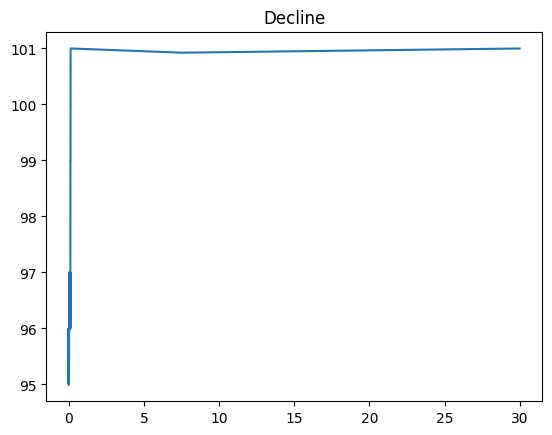

In [20]:
plt.plot(result.t_history, result.y_history[0,:].T)
plt.title("Decline")
plt.show()

# Pure Gillespie

In [7]:
from hybrid.gillespie import GillespieSimulator

g_simulator = GillespieSimulator(
    m.get_k(jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
    jit=True,
)

In [8]:
result = g_simulator.simulate(
    (0.0, 100.0),
    [1000.0],
    rng = np.random.default_rng(),
)

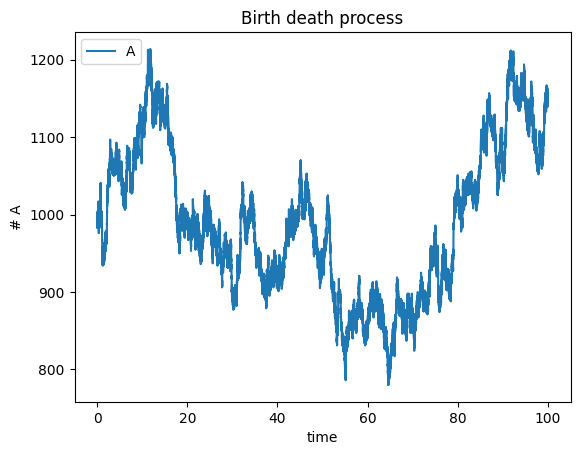

In [9]:
plt.plot(result.t_history, result.y_history.T)
plt.title("Birth death process")
plt.legend(['A'], loc='upper left')
plt.xlabel('time')
plt.ylabel('# A')
plt.savefig('birthdeath.png', bbox_inches='tight', dpi=200)
plt.show()


# Tau leaping

In [10]:
from hybrid.tau import TauLeapSimulator

t_simulator = TauLeapSimulator(
    m.get_k(jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
    jit=True,
)

In [11]:
result = t_simulator.simulate(
    (0.0, 100.0),
    [10.0],
    rng = np.random.default_rng(),
)

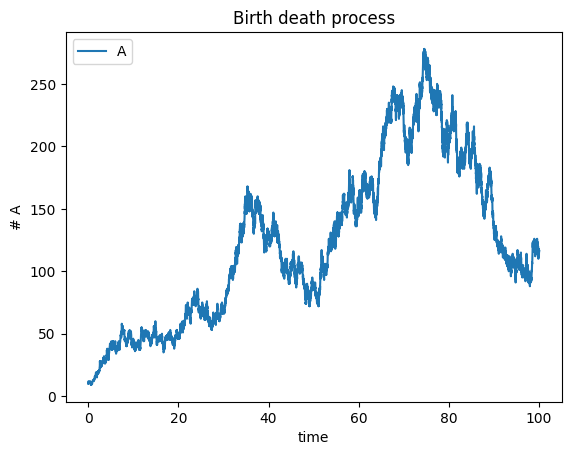

In [12]:
plt.plot(result.t_history, result.y_history.T)
plt.title("Birth death process")
plt.legend(['A'], loc='upper left')
plt.xlabel('time')
plt.ylabel('# A')
plt.savefig('birthdeath.png', bbox_inches='tight', dpi=200)
plt.show()

In [13]:
result

History(t=100.0, y=array([116.]), t_history=array([0.00000000e+00, 2.11431374e-02, 8.47704392e-02, ...,
       9.99933789e+01, 9.99964871e+01, 1.00000000e+02]), y_history=array([[ 10.,  11.,  12., ..., 117., 116., 116.]]), status_counter=Counter({<TauStepStatus.gillespie_stochastic: 3>: 24396, <TauStepStatus.rejected_for_gillespie: -2>: 244, <TauStepStatus.gillespie_t_end: 2>: 1}))

# Linear birth / death decay

In [14]:
S1 = Species('S1')

reactions = [
    Reaction([S1], [], k='mu'),
    Reaction([S1], [(S1, 2)], k='lmbda')
]

m = Model([S1], reactions)

In [23]:
p = {'mu': 1.0, 'lmbda': 0.9}

s = GillespieSimulator(
    m.get_k(parameters=p, jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
)

Evaluating expression: mu => 1.0
Evaluating expression: lmbda => 0.9


In [27]:
def halter(t, y):
    return y[0] == 0

t_ends = []
for i in range(1000):
    result = s.simulate([0.0, 100.0], m.make_initial_condition({'S1': 100}), np.random.default_rng(), halt=halter)
    t_ends.append(result.t)

In [29]:
t_ends = np.array(t_ends)

t_ends.mean()

29.407198939812364

In [35]:
1/(p['mu'] - p['lmbda']) * np.log(100)

46.05170185988093